<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/multi_ticker_deep_sarsa_walkforward_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --force-reinstall \
    dask==2024.11.2 \
    rapids-dask-dependency==24.12.0 \
    cudf-cu12==24.12.0 \
    cuml-cu12==24.12.0 \
    pylibraft-cu12==24.12.0 \
    pylibcudf-cu12==24.12.0 \
    numba==0.61.0 --quiet

In [ ]:

#Install Stable Baselines3 and Trading Libraries
!pip install stable-baselines3[extra] gymnasium gym-anytrading yfinance xgboost joblib


In [ ]:
#Clean install of TensorFlow compatible with Colab's GPU (CUDA 11.8 + cuDNN 8.x)
!pip install tensorflow==2.12.0

#Restart runtime after this!
!pip install numpy==1.24.4 --force-reinstall

In [4]:
import torch
import cudf
import cuml
import dask
import pandas as pd
import numpy as np
import scipy
import lightgbm as lgb
import gymnasium as gym
import stable_baselines3

#Version Checks
print(" Library Versions")
print("--------------------")
print(" PyTorch:", torch.__version__)
print(" CUDA:", torch.version.cuda)
print(" cuDF:", cudf.__version__)
print(" cuML:", cuml.__version__)
print(" Dask:", dask.__version__)
print(" Pandas:", pd.__version__)
print(" NumPy:", np.__version__)
print(" SciPy:", scipy.__version__)
print(" LightGBM:", lgb.__version__)
print(" Gymnasium:", gym.__version__)
print(" Stable Baselines3:", stable_baselines3.__version__)

# GPU Check (Torch + NVIDIA)
print("\n GPU Availability")
print("--------------------")
print(" PyTorch GPU Available:", torch.cuda.is_available())
print(" GPU Count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print(" GPU Name:", torch.cuda.get_device_name(0))

 Library Versions
--------------------
 PyTorch: 2.6.0+cu124
 CUDA: 12.4
 cuDF: 24.12.00
 cuML: 24.12.00
 Dask: 2024.11.2
 Pandas: 2.2.3
 NumPy: 1.24.4
 SciPy: 1.15.2
 LightGBM: 4.5.0
 Gymnasium: 1.1.1
 Stable Baselines3: 2.6.0

 GPU Availability
--------------------
 PyTorch GPU Available: True
 GPU Count: 1
 GPU Name: Tesla T4


In [1]:
#Clean install of TensorFlow compatible with Colab's GPU (CUDA 11.8 + cuDNN 8.x)
!pip uninstall -y tensorflow keras
!pip install tensorflow==2.12.0

#Restart runtime after this!
!pip install numpy==1.24.4 --force-reinstall

  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)
Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 1.23.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.30 which is incompatible.
xarray 2025.3.1 requires numpy

In [4]:
#Core & System Utilities
import os
import gc
import sys
import time
import json
import pickle
import random
from datetime import datetime
from collections import defaultdict, deque

#Data Science Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba

#Financial Data
import yfinance as yf

#Machine Learning & Preprocessing
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

#Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Input, backend as K
from tensorflow.keras import mixed_precision

#Visualization & Display
import IPython.display as display

#RAPIDS Libraries (for GPU-accelerated ML, optional)
import cupy as cp

#Reinforcement Learning (Stable Baselines3)
import stable_baselines3
from stable_baselines3 import A2C, DDPG, DQN, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

#Gym & Trading Environments
import gym
import gymnasium as gym
import gym_anytrading
from gym.spaces import Box
from gymnasium.spaces import Box as GymBox, Discrete
from gymnasium.wrappers import TimeLimit

#CUDA (Optional Paths - for manual GPU configuration)
os.environ['CUDA_HOME'] = '/usr/local/cuda-11.8'
os.environ['PATH'] += ':/usr/local/cuda-11.8/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-11.8/lib64'

#GPU Check (Colab only)
!nvidia-smi


Thu May  1 01:59:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Required for TensorFlow compatibility (GPU + cuDNN)
!pip uninstall -y tensorflow keras -q
!pip install tensorflow==2.12.0 -q



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 1.23.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.30 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
orbax-checkpoint 0.11.12 requires jax>=0.5.0, but you have jax 0.4.30 which is incompatibl

In [6]:
# Fix protobuf compatibility
!pip install protobuf==3.20.3 -q

# Essential packages
!pip install numpy==1.24.4 pandas joblib yfinance scikit-learn matplotlib -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.30 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
bigframes 2.1.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
orbax-checkpoint 0.11.12 requires jax>=0.5.0, but you have jax 0.4.30 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but yo

In [7]:
import os
from google.colab import drive

if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print("ogle Drive is already mounted.")



Mounted at /content/drive


In [8]:
#Downgrade NumPy to a compatible version
!pip install numpy==1.24.4 --force-reinstall

#Reinstall LightGBM after fixing NumPy
!pip install lightgbm --force-reinstall --no-cache-dir


  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.30 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
bigframes 2.1.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
orbax-checkpoint 0.11.12 requires jax>=0.5.0, but you have j

In [ ]:
!pip install -U scikit-learn==1.3.2 --quiet


In [9]:
!pip install yfinance

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 75.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.2.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.30 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
bigframes 2.1.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
orbax-checkpoint 0.11.12 requires jax>=0.5.0, but you have jax 0.4.30 which is i


Training AAPL | 2023-06-01 → 2025-04-28
Saved: ./deep_sarsa_walkforward_models/deep_sarsa_AAPL_2023-06-01_to_2025-04-28.pth | Reward: 0.17

Training TSLA | 2023-06-01 → 2025-04-28
Saved: ./deep_sarsa_walkforward_models/deep_sarsa_TSLA_2023-06-01_to_2025-04-28.pth | Reward: 0.31

Training MSFT | 2023-06-01 → 2025-04-28
Saved: ./deep_sarsa_walkforward_models/deep_sarsa_MSFT_2023-06-01_to_2025-04-28.pth | Reward: -0.16

Training GOOG | 2023-06-01 → 2025-04-28
Saved: ./deep_sarsa_walkforward_models/deep_sarsa_GOOG_2023-06-01_to_2025-04-28.pth | Reward: -0.11

Training AMZN | 2023-06-01 → 2025-04-28
Saved: ./deep_sarsa_walkforward_models/deep_sarsa_AMZN_2023-06-01_to_2025-04-28.pth | Reward: 0.10

Training NVDA | 2023-06-01 → 2025-04-28
Saved: ./deep_sarsa_walkforward_models/deep_sarsa_NVDA_2023-06-01_to_2025-04-28.pth | Reward: 0.01

Training META | 2023-06-01 → 2025-04-28
Saved: ./deep_sarsa_walkforward_models/deep_sarsa_META_2023-06-01_to_2025-04-28.pth | Reward: 0.17

Training JPM | 20

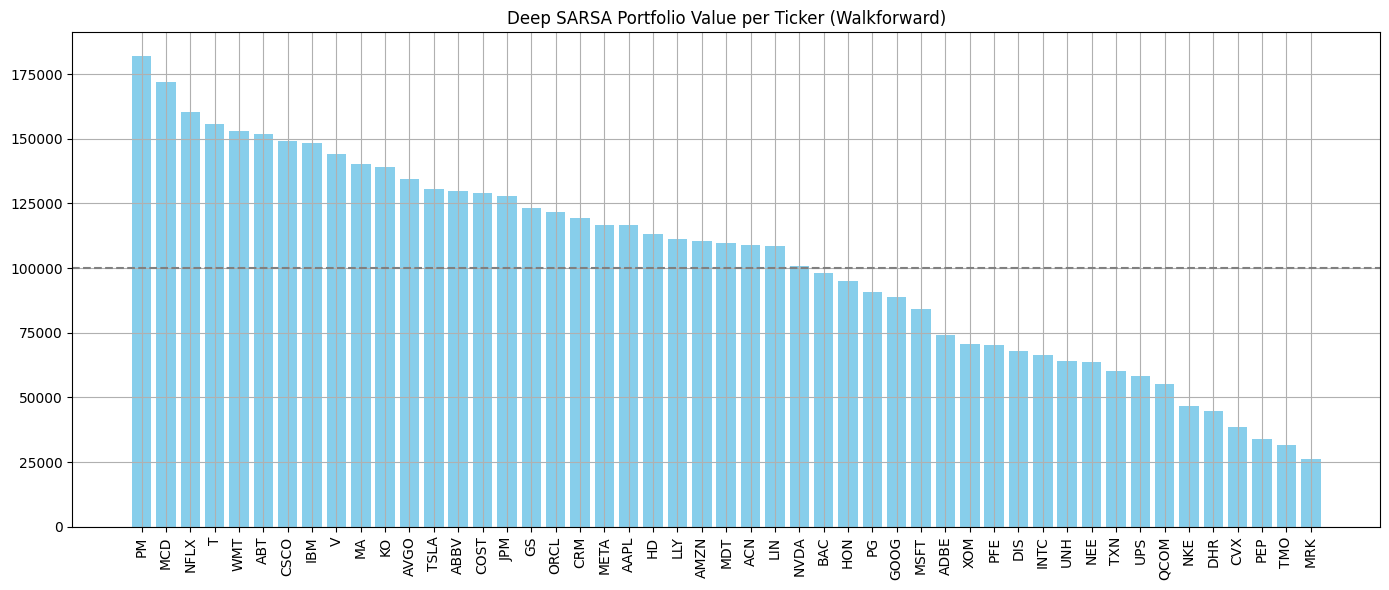

In [13]:
# Deep SARSA Walkforward (Fixed for 1h Yahoo Limit)
import os, gc, random
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Config
TICKERS = [
    "AAPL", "TSLA", "MSFT", "GOOG", "AMZN", "NVDA", "META", "JPM", "BAC", "WMT",
    "UNH", "V", "PG", "HD", "MA", "DIS", "PEP", "KO", "CSCO", "ADBE", "CRM", "NFLX",
    "PFE", "MRK", "T", "ORCL", "ABBV", "CVX", "XOM", "ABT", "COST", "QCOM", "INTC",
    "MCD", "NKE", "DHR", "LLY", "MDT", "TMO", "TXN", "PM", "AVGO", "NEE", "ACN", "UPS",
    "HON", "LIN", "GS", "IBM"
]
SEQUENCE_LENGTH = 60
SAVE_DIR = "./deep_sarsa_walkforward_models"
os.makedirs(SAVE_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature Engineering
def compute_technical_indicators(df):
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_20'] = df['Close'].ewm(span=20).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / (loss + 1e-6)
    df['RSI'] = 100 - (100 / (1 + rs))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
    df['ATR'] = df['High'].rolling(14).max() - df['Low'].rolling(14).min()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df.dropna(inplace=True)
    return df

# Deep SARSA Model
class DQNNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 32)
        self.out = nn.Linear(32, output_dim)

    def forward(self, x):
        h, _ = self.lstm(x)
        h = h[:, -1, :]
        x = torch.relu(self.fc1(h))
        return self.out(x)

class DeepSARSAAgent:
    def __init__(self, input_dim, action_dim, lr=1e-3, gamma=0.99):
        self.gamma = gamma
        self.model = DQNNet(input_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, 2)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def update(self, state, action, reward, next_state, next_action, done):
        q_values = self.model(state)
        next_q_values = self.model(next_state)
        target = reward + self.gamma * next_q_values[0, next_action] * (1 - int(done))
        loss = self.criterion(q_values[0, action], target.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Train/Eval
def train_agent_on_split(train_X, test_X, episodes=5):
    agent = DeepSARSAAgent(train_X.shape[2], 3)
    for ep in range(episodes):
        idx = random.randint(0, len(train_X) - 2)
        state = torch.tensor(train_X[idx][None], dtype=torch.float32).to(device)
        action = agent.select_action(state, epsilon=1.0 - ep / episodes)
        for t in range(idx, len(train_X) - 1):
            next_state = torch.tensor(train_X[t+1][None], dtype=torch.float32).to(device)
            reward = float(train_X[t+1, -1, 0] - train_X[t, -1, 0])
            done = t + 2 == len(train_X)
            next_action = agent.select_action(next_state, epsilon=1.0 - ep / episodes)
            agent.update(state, action, reward, next_state, next_action, done)
            if done: break
            state, action = next_state, next_action

    test_rewards = []
    for t in range(len(test_X) - 1):
        state = torch.tensor(test_X[t][None], dtype=torch.float32).to(device)
        action = agent.select_action(state, epsilon=0.0)
        next_state = torch.tensor(test_X[t+1][None], dtype=torch.float32).to(device)
        reward = float(test_X[t+1, -1, 0] - test_X[t, -1, 0])
        test_rewards.append(reward)

    return np.sum(test_rewards), agent

# Date-Based Walkforward
train_start = "2023-06-01"
train_end = "2024-06-01"
test_start = "2024-06-01"
test_end = "2025-04-28"

def date_based_walkforward_train(ticker):
    print(f"\nTraining {ticker} | {train_start} → {test_end}")
    df = yf.download(ticker, start=train_start, end=test_end, interval="1h", progress=False)
    if df.empty:
        print(f"{ticker}: No data.")
        return None

    df = compute_technical_indicators(df)
    features = ['Close', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'Signal_Line', 'ATR', 'OBV']
    scaled = MinMaxScaler().fit_transform(df[features])
    df_scaled = pd.DataFrame(scaled, index=df.index, columns=features)

    sequences = [(df_scaled.index[i], df_scaled.iloc[i - SEQUENCE_LENGTH:i].values)
                 for i in range(SEQUENCE_LENGTH, len(df_scaled))]

    train_X = np.array([x[1] for x in sequences if train_start <= x[0].strftime('%Y-%m-%d') < train_end])
    test_X = np.array([x[1] for x in sequences if test_start <= x[0].strftime('%Y-%m-%d') < test_end])

    if len(train_X) < 10 or len(test_X) < 10:
        print(f"{ticker}: Insufficient data.")
        return None

    reward, agent = train_agent_on_split(train_X, test_X)
    model_path = f"{SAVE_DIR}/deep_sarsa_{ticker}_{train_start}_to_{test_end}.pth"
    torch.save(agent.model.state_dict(), model_path)
    print(f"Saved: {model_path} | Reward: {reward:.2f}")
    return reward

# Run All
results = {}
for ticker in TICKERS:
    reward = date_based_walkforward_train(ticker)
    results[ticker] = reward if reward is not None else 0
    gc.collect()
    torch.cuda.empty_cache()

# Save Results
df = pd.DataFrame(results.items(), columns=["Ticker", "Reward"])
df["Portfolio_Value"] = 100000 * (1 + df["Reward"])
df = df.sort_values("Portfolio_Value", ascending=False)
os.makedirs("results", exist_ok=True)
df.to_csv("results/sarsa_walkforward_summary.csv", index=False)

print("\nTop 5:")
print(df.head())

print("\nBottom 5:")
print(df.tail())

# Plot
plt.figure(figsize=(14, 6))
plt.bar(df["Ticker"], df["Portfolio_Value"], color='skyblue')
plt.axhline(100000, linestyle='--', color='gray')
plt.title("Deep SARSA Portfolio Value per Ticker (Walkforward)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()


In [14]:
gc.collect

<function gc.collect(generation=2)>